In [1]:
# Import Dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:

import numpy as np
import pandas as pd
from scipy.stats import stats
from statistics import mean
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [16]:
# Display the information in the measurement table in dictionary format.
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x120de55b0>,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'prcp': 0.08}

In [51]:
# Find the most recent date in the data set by descending order.
first_date = session.query(Measurement.date).order_by(Measurement.date).first()
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"First date: {first_date[0]} , Latest date: {latest_date[0]}")

First date: 2010-01-01 , Latest date: 2017-08-23


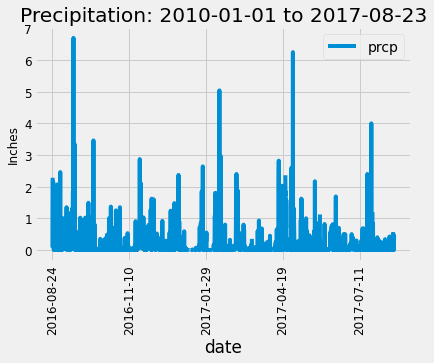

In [52]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = list(np.ravel(latest_date))[0]

latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

latest_Year = int(dt.datetime.strftime(latest_date, '%Y'))
latest_Month = int(dt.datetime.strftime(latest_date, '%m'))
latest_Day = int(dt.datetime.strftime(latest_date, '%d'))

# Calculate the date one year from the last date in data set.
yearBefore = dt.date(latest_Year, latest_Month, latest_Day) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rainData = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > yearBefore)
                  .order_by(Measurement.date)
                  .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
rainTable = pd.DataFrame(rainData)
rainTable = rainTable.set_index('date')

# Sort the dataframe by date
rainTable = rainTable.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
rainTable.plot(title="Precipitation: 2010-01-01 to 2017-08-23", fontsize=12)
plt.ylabel("Inches" , fontsize=12)
plt.xticks(rotation='vertical')
plt.savefig('Output/Precipitation.png')
plt.show()


In [53]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rainTable.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [54]:
# Design a query to calculate the total number stations in the dataset
stationsCount = session.query(Station).count()
print(f"Station Count: {stationsCount}")

Station Count: 9


In [56]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stationCounts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
stationCounts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [57]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stationID = stationCounts[0][0]

stationName = (session.query(Station.name)
                      .filter_by(station = stationID))
stationName = stationName[0][0]
print(f"The most active station is {stationID}: {stationName}.")

#query for lowest temperature
lowestTemp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == stationID)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowestTemp = lowestTemp[0]
print(f"The lowest temperature recorded there is {lowestTemp} degrees Farenheit.")

#query for highest temperature
highestTemp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == stationID)
                      .order_by(Measurement.tobs.desc())
                      .first())
highestTemp = highestTemp[0]
print(f"The highest temperature recorded there is {highestTemp} degrees Farenheit.")

#query for average temperature
avgTemp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == stationID))
avgTemp = '{0:.3}'.format(avgTemp[0][0])
print(f"The average temperature recorded there is {avgTemp} degrees Farenheit.")

The most active station is USC00519281: WAIHEE 837.5, HI US.
The lowest temperature recorded there is 54.0 degrees Farenheit.
The highest temperature recorded there is 85.0 degrees Farenheit.
The average temperature recorded there is 71.7 degrees Farenheit.


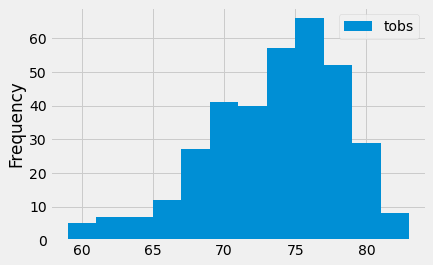

In [60]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempData = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > yearBefore)
                   .filter(Measurement.station == stationID)
                   .order_by(Measurement.date)
                   .all())
#convert query object to data frame
tempTable = pd.DataFrame(tempData)
tempTable = tempTable.set_index('date')

#sory by date
tempTable = tempTable.sort_index(ascending=True)

#histogram plot with pandas
tempTable.plot(kind='hist', bins=12)

plt.savefig('Output/station-histogram.png')

# Close session

In [62]:
# Close Session
session.close()